# TMDB movie rating

## 1. Objective
In this notebook, we aim to analyze moving rating data provided by TMDB and build up a movie recommendation engine.

Generally speaking, three methods are widely adopted in building up recommendation system, and they are often combined due to the attributes of each method.For TMDB dataset, we will mainly use Popularity-based and Content-based methods. We will do Collaboratie-filtering with another dataset.
1. Popularity-based recommendation
2. Content-based recommendation
3. Collaboratie-filtering recommendation

## 2. Data Preprocessing

### 2.1 Data Loading
The codes used for data loading belongs entirely to https://www.kaggle.com/fabiendaniel/film-recommendation-engine/data

In [ ]:
import numpy as np
import pandas as pd
from functools import reduce
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import math, nltk, warnings
from nltk.corpus import wordnet
from sklearn import linear_model
from sklearn.neighbors import NearestNeighbors

In [ ]:
import json

#___________________________
def load_tmdb_movies(path):
    df = pd.read_csv(path)
    df['release_date'] = pd.to_datetime(df['release_date']).apply(lambda x: x.date())
    json_columns = ['genres', 'keywords', 'production_countries',
                    'production_companies', 'spoken_languages']
    for column in json_columns:
        df[column] = df[column].apply(json.loads)
    return df
#___________________________
def load_tmdb_credits(path):
    df = pd.read_csv(path)
    json_columns = ['cast', 'crew']
    for column in json_columns:
        df[column] = df[column].apply(json.loads)
    return df
#___________________
LOST_COLUMNS = [
    'actor_1_facebook_likes',
    'actor_2_facebook_likes',
    'actor_3_facebook_likes',
    'aspect_ratio',
    'cast_total_facebook_likes',
    'color',
    'content_rating',
    'director_facebook_likes',
    'facenumber_in_poster',
    'movie_facebook_likes',
    'movie_imdb_link',
    'num_critic_for_reviews',
    'num_user_for_reviews']
#____________________________________
TMDB_TO_IMDB_SIMPLE_EQUIVALENCIES = {
    'budget': 'budget',
    'genres': 'genres',
    'revenue': 'gross',
    'title': 'movie_title',
    'runtime': 'duration',
    'original_language': 'language',
    'keywords': 'plot_keywords',
    'vote_count': 'num_voted_users'}
#_____________________________________________________
IMDB_COLUMNS_TO_REMAP = {'imdb_score': 'vote_average'}
#_____________________________________________________
def safe_access(container, index_values):
    # return missing value rather than an error upon indexing/key failure
    result = container
    try:
        for idx in index_values:
            result = result[idx]
        return result
    except IndexError or KeyError:
        return pd.np.nan
#_____________________________________________________
def get_director(crew_data):
    directors = [x['name'] for x in crew_data if x['job'] == 'Director']
    return safe_access(directors, [0])
#_____________________________________________________
def pipe_flatten_names(keywords):
    return '|'.join([x['name'] for x in keywords])
#_____________________________________________________
def convert_to_original_format(movies, credits):
    tmdb_movies = movies.copy()
    tmdb_movies.rename(columns=TMDB_TO_IMDB_SIMPLE_EQUIVALENCIES, inplace=True)
    tmdb_movies['title_year'] = pd.to_datetime(tmdb_movies['release_date']).apply(lambda x: x.year)
    # I'm assuming that the first production country is equivalent, but have not been able to validate this
    tmdb_movies['country'] = tmdb_movies['production_countries'].apply(lambda x: safe_access(x, [0, 'name']))
    tmdb_movies['language'] = tmdb_movies['spoken_languages'].apply(lambda x: safe_access(x, [0, 'name']))
    tmdb_movies['director_name'] = credits['crew'].apply(get_director)
    tmdb_movies['actor_1_name'] = credits['cast'].apply(lambda x: safe_access(x, [1, 'name']))
    tmdb_movies['actor_2_name'] = credits['cast'].apply(lambda x: safe_access(x, [2, 'name']))
    tmdb_movies['actor_3_name'] = credits['cast'].apply(lambda x: safe_access(x, [3, 'name']))
    tmdb_movies['genres'] = tmdb_movies['genres'].apply(pipe_flatten_names)
    tmdb_movies['plot_keywords'] = tmdb_movies['plot_keywords'].apply(pipe_flatten_names)
    return tmdb_movies

In [ ]:
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"
pd.options.display.max_columns = 50
%matplotlib inline
warnings.filterwarnings('ignore')
PS = nltk.stem.PorterStemmer()

In [ ]:
from subprocess import check_output
print(check_output(["ls","../input/"]))

In [ ]:
# load the dataset
#credits = load_tmdb_credits("/Users/machen/Documents/000 MSBA/452 Machine Learning/HW3 TMDB MOVIE/tmdb/tmdb_5000_credits.csv")
#movies = load_tmdb_movies("/Users/machen/Documents/000 MSBA/452 Machine Learning/HW3 TMDB MOVIE/tmdb/tmdb_5000_movies.csv")
credits = load_tmdb_credits("../input/tmdb_5000_credits.csv")
movies = load_tmdb_movies("../input/tmdb_5000_movies.csv")
df_initial = convert_to_original_format(movies, credits)
df_initial = convert_to_original_format(movies, credits)
print('Shape:',df_initial.shape)

### 2.2 Missing Values

In [ ]:
# info on variable types and filling factor
tab_info=pd.DataFrame(df_initial.dtypes).T.rename(index={0:'column type'})
tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().sum()).T.rename(index={0:'null values'}))
tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().sum()/df_initial.shape[0]*100).T.
                         rename(index={0:'null values (%)'}))
tab_info

## 3. Recommendation Systems

### 3.1 Demographic Filtering Recommendation
In order to demonstate how a movie is liked by users, vote average and number of voted users are combined to formulate a new metric. The formula is used by IMDB (https://www.kaggle.com/ibtesama/getting-started-with-a-movie-recommendation-system)
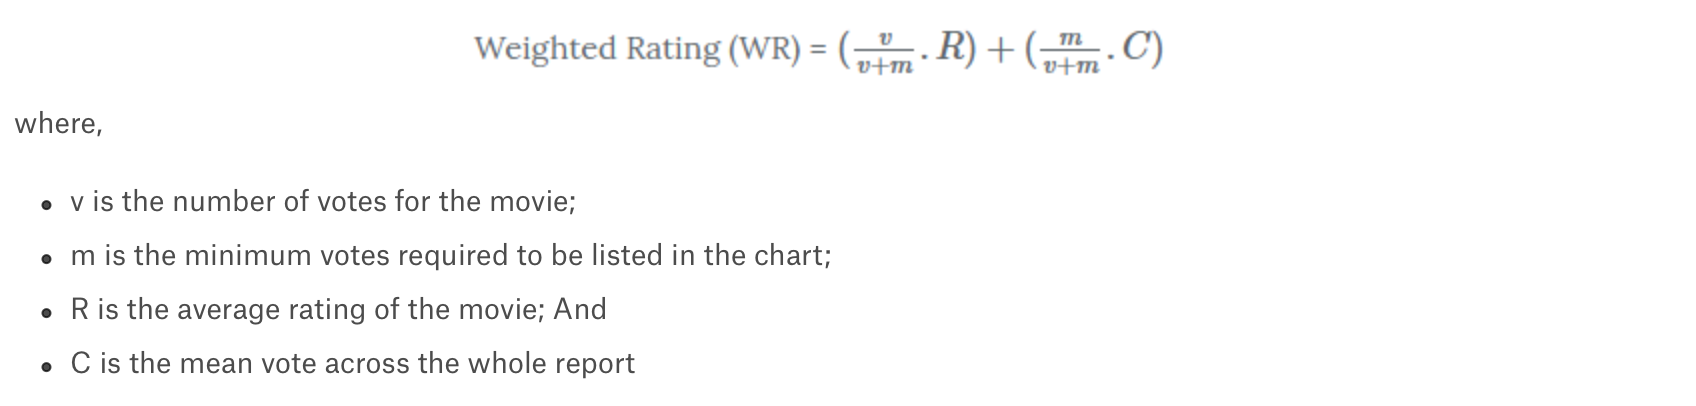

**Advantages**
1. Can be used to solve "cold-start" issue, meaning recommending movies for new users, where user-level preference information is missing.

**Disadvantages**
1. Can not make personalized recommendation, though combinded with cookie information, it can make recommendations like "what's popular around".
2. Can not make minority recommendation. Moives with high rating but small number of ratings do not stand out in this algorithum.

**Improvements**
1. The formula does not take **recent pupularity trend** into consideration. Some movies which have been on shelf for a long time such as The Shawshank Redemption(1994), have accumulate large amounts of votes, compared with newly released movies. If we want to recommend more popular movies to viewers, the more recent a rating is, the higher weight is has.

We already have v(vote_count) and R (vote_average) and C can be calculated as：

In [ ]:
C = df_initial['vote_average'].mean()
C

The next step is to determine an appropriate value for m, the minimum votes required to be listed in the chart. We will use 90th percentile as our cutoff. In other words, for a movie to feature in the charts, it must have more votes than at least 90% of the movies in the list.

In [ ]:
m = df_initial['num_voted_users'].quantile(q=0.9)
m

Filter the movies qualified for number of votes(votes > 1838)

In [ ]:
movies = df_initial.copy().loc[df_initial['num_voted_users']>= m]
movies.shape

Now, we need to calculate our metric for each qualified movie. To do this, we will define a function, weighted_rating() and define a new feature score, of which we'll calculate the value by applying this function to our DataFrame of qualified movies:

In [ ]:
def weighted_rating(x, m=m, C=C):
    v = x['num_voted_users']
    R = x['vote_average']
    # Calculation based on the IMDB formula
    return (v/(v+m) * R) + (m/(m+v) * C)

In [ ]:
# Define a new feature 'score' and calculate its value with `weighted_rating()`
movies['weighted_score'] = movies.apply(weighted_rating, axis=1)

Finally, let's sort the DataFrame based on the score feature and output the title, vote count, vote average and weighted rating or score of the top 10 movies.

In [ ]:
#Sort movies based on score calculated above
movies = movies.sort_values(by = 'weighted_score', ascending=False, axis = 0)

#Print the top 10 movies
movies[['movie_title','weighted_score','title_year','director_name']].head(10)

### 3.2 Content-Based Filtering Recommendation

Content-based filtering is to recommend new items similar to previous item that has already been liked by user.

#### Generally, the construction of a content-based filtering consists of the following three steps: 

**1. Establish item profile**

Collect attributes that can be used to describe items and distinguish between items. Use 0-1 matrix to represent whether a item has the attribute. For example, for movie director, we can collect all directors as attributes. For a spcific movie like "Matrix", denote 1 for "Lana Wachowski" and "Lilly Wachowski", 0 for other directors.

**2. Establish user profile**

This process is similar to establishing item profile, except for user preference for a attribute is calculated by the average rating of items with the attribute. For example, user's preference for director "Lana Wachowski" is the average of all movies directed by "Lana Wachowski", which have been watched by the user.

**3. Calculate similarity between item and user**

Calculate similarity based on distance definition like cosine, L2. And recommend items which have the smallest distance from user.


For TMDB data, we're going to establish content-based recommendation with genres, directors, actors, and movie keywords.

#### Advantages

**1. User independence** CB is based entirely on one user's preference and the attributes of all items. It's independent of other users' preference. Hence no matter how other people cheat on item preference(like brushing tickets), the recommendation stays unchanged. While Collaborative-filtering relies entirely on other users' preference.

**2. Interpretability** Easy to interpret and explain to non-tech people.

**3. Can deal with new item "cold-start' issue** If a new item is added to the database, it has the same chance as existing items to be recommended to user. Hence it can deal with new item cold-start issue. While Collaborative-filtering will not recommend a new item until it has been rated by some user.  


#### Disadvantages

**1. Hard to extract attributes** Extract attributes to represent items is challenging, for example we can use director, actors, genres to represent a movie, but these are only part of information.


**2. Can not find potential user interest** CB will only recommend movies similar to the ones user has already watched. It can not uncover user's potential interest.


**3. Can deal with new user "cold-start" issue** New user do not have preference data, hence no recommendations can be made with CB.

### 3.2.1 Use keywords, Genres, Director, Actors

#### Data preprocessing: 
- remove "|" for genres and plot keywords;
- strip space between first name and last name, because we want the model to treat first name and last name as whole.

In [ ]:
df_initial['genres'] = df_initial['genres'].str.split('|')
df_initial['plot_keywords'] = df_initial['plot_keywords'].str.split('|')

In [ ]:
features = ['genres', 'plot_keywords', 'director_name', 'actor_1_name','actor_2_name','actor_3_name']
df_initial[features].head()

In [ ]:
# Function to convert all strings to lower case and strip names of spaces
def clean_data(x):
    #for genres and plot_keywords
    if isinstance(x, list):
        return [str.lower(i.replace(" ", "")) for i in x]
    else:
        #for director, actors
        if isinstance(x, str):
            return str.lower(x.replace(" ", ""))
        else:
            return ''

In [ ]:
# Apply clean_data function to your features.
for feature in features:
    df_initial[feature] = df_initial[feature].apply(clean_data)

In [ ]:
df_initial[features].head()

In [ ]:
# Function to join all attributes
def create_soup(x):
    return ' '.join(x['plot_keywords']) + ' ' + ' '.join(x['actor_1_name']) + ' ' + ' '.join(x['director_name']) + ' ' + ' '.join(x['genres'])+ ' ' + ' '.join(x['actor_2_name'])+ ' ' + ' '.join(x['actor_3_name'])

In [ ]:
# Apply create_soup function to your df
df_initial['soup'] = df_initial.apply(create_soup, axis =1)
df_initial['soup'].head()

#### Convert the collection of text documents, to a matrix of token counts

In [ ]:
# Import CountVectorizer and create the count matrix
from sklearn.feature_extraction.text import CountVectorizer

count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(df_initial['soup'])

In [ ]:
# Compute the Cosine Similarity matrix based on the count_matrix
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim1 = cosine_similarity(count_matrix, count_matrix)

### 3.2.2 Use Overview (Plot)

TF-IDF is widely used as the last pre-processing step in NLP. It identifies word frequency, reduces the impact of the words that are more common in the corpus, and transforms text data into matrix for modelling.

Broadly speaking, if a word occurs many times in a document it is likely to be important. However, if it also appears frequently across multiple documents then it may just be a common word and not in fact very meaningful. 

In [ ]:
#Import TfIdfVectorizer from scikit-learn
from sklearn.feature_extraction.text import TfidfVectorizer

#Define a TF-IDF Vectorizer Object. Remove all english stop words such as 'the', 'a'
tfidf = TfidfVectorizer(stop_words='english')

#Replace NaN with an empty string
df_initial['overview'] = df_initial['overview'].fillna('')

#Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_matrix = tfidf.fit_transform(df_initial['overview'])

#Output the shape of tfidf_matrix
tfidf_matrix.shape

# Import linear_kernel
from sklearn.metrics.pairwise import linear_kernel

# Compute the cosine similarity matrix
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

### 3.2.3 Recommendation based on cosine similarity

In [ ]:
# Reset index of our main DataFrame and construct reverse mapping as before
df_initial = df_initial.reset_index()
indices = pd.Series(df_initial.index, index=df_initial['movie_title'])
indices.head()

In [ ]:
# Function that takes in movie title as input and outputs most similar movies
def get_recommendations(title, cosine_sim=cosine_sim):
    # Get the index of the movie that matches the title
    idx = indices[title]

    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:11]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return df_initial['movie_title'].iloc[movie_indices]

#### Recommendation for movie "The Shawshank Redemption" based on plot similarity:

In [ ]:
get_recommendations('The Shawshank Redemption')

#### Recommendation for movie "The Shawshank Redemption" based on genre/keyword/director/actors similarity:

In [ ]:
get_recommendations('The Shawshank Redemption',cosine_sim1)